## HW8 for CS 498 - Applied Machine Learning

Students:
Cristian Jansenson
Peter Tsapatsaris


In [17]:
import pandas as pd
import numpy as np
import math 
import mnist
import scipy.misc
import copy
from pylab import imshow, show

### Get data and binarize

In [3]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()
from sklearn import preprocessing
norm_images = train_images/255
bin_images = np.empty([60000,28,28])
for i in range(60000):
    bin_images[i] = preprocessing.binarize(norm_images[i], threshold=0.5, copy=True)
    bin_images[i] = np.where(bin_images[i] == 0, -1, 1)

### Add noise

In [4]:
noiseDF = pd.read_csv('NoiseCoordinates.csv')

In [5]:
for imageNum in range(20):
    rowBits = noiseDF.iloc[2 * imageNum][1:]
    colBits = noiseDF.iloc[2 * imageNum + 1][1:]
    #print('Image:' + str(imageNum))
    for bit in range(15):
        #print(rowBits[bit], colBits[bit])
        if bin_images[imageNum][rowBits[bit]][colBits[bit]] == -1:
            bin_images[imageNum][rowBits[bit]][colBits[bit]] = 1
        else:
            bin_images[imageNum][rowBits[bit]][colBits[bit]] = -1
   

### Add noise

In [6]:
Q = pd.read_csv('InitialParametersModel.csv', header=None)
updateOrder = pd.read_csv('UpdateOrderCoordinates.csv')

def buildQList(Q, numOfImages):
    l = []
    for i in range(numOfImages):
        l.append(np.copy(Q))
    return l

QList = buildQList(Q, 20)

In [7]:
theta1 = .8
theta2 = 2
epsilon = 1e-10
def calcEqLogQ(Q):
    res = 0
    for r in range(28):
        for c in range(28): 
            res = res + Q[r][c] *  np.log(Q[r][c] + epsilon)
            res = res + (1 - Q[r][c]) *  np.log(1 - Q[r][c] + epsilon)
            
    #print('eqlog:' + str(res))
    return res

def calcEqLogP(imgNumber, QList, bin_images):
    img = bin_images[imgNumber]
    Q = QList[imgNumber]
    res = 0
    for r in range(28):
        for c in range(28):  
            if c > 0:
                res = res + theta1 * (2 * Q[r][c] - 1) * (2 * Q[r][c - 1] - 1)
            if c < 27:    
                res = res + theta1 * (2 * Q[r][c] - 1) * (2 * Q[r][c + 1] - 1)
            if r > 0:
                res = res + theta1 * (2 * Q[r][c] - 1) * (2 * Q[r - 1][c] - 1)
            if r < 27:
                res = res + theta1 * (2 * Q[r][c] - 1) * (2 * Q[r + 1][c] - 1)
            
            res = res + theta2 * (2 * Q[r][c] - 1) * img[r][c]
    #print('EqLogP:' + str(res))
    return res
    
def calcEq(imgNumber, QList, binImages):
    return calcEqLogQ(QList[imgNumber]) - calcEqLogP(imgNumber, QList, binImages) 



In [19]:
def getNextExtQ(imgNumber, ExtQList, bin_images, updateOrder):
    oriQ = ExtQList[imgNumber]
    newExtQ = np.copy(ExtQList[imgNumber])
    rowIdx = updateOrder.iloc[imgNumber * 2]
    colIdx = updateOrder.iloc[imgNumber * 2 + 1]
    img = bin_images[imgNumber]
    for counter in range(1, 28*28+1):
        r = rowIdx[counter]
        c = colIdx[counter]
        #print (r,c)
        posSum = 0
        if c > 0:
            posSum = posSum + theta1 * (2*newExtQ[r][c - 1] -1)
        if c < 27:
            posSum = posSum + theta1 * (2*newExtQ[r][c + 1] -1)
        if r > 0:
            posSum = posSum + theta1 * (2*newExtQ[r - 1][c] -1)
        if r < 27:
            posSum = posSum + theta1 * (2*newExtQ[r + 1][c] -1)
        posSum = posSum + theta2 * img[r][c]
        num = math.exp(posSum)
        den = math.exp(posSum) + math.exp(-posSum)
        res = num/den
        newExtQ[r][c] = res    
    return newExtQ

# Input is bin_images[index]
def showImage(pic):
    imshow(pic, cmap='gray')
    show()

In [9]:
calcEq(0, QList, bin_images) 
#QList[0] = getNextExtQ(0, QList, bin_images, updateOrder)

-425.34792867180096

### Perform 10 iterations of algorithm

In [10]:
ExtQList =  np.asarray(buildQList(Q, 20))
eValues = np.zeros((20,11))
first10 = np.empty((28,0))
second10 = np.empty((28,0))
allBuilt = np.empty((28,0))

In [11]:
newQList = np.copy(ExtQList)

for i in range(0,20):
    eValues[i][0] = calcEq(i, newQList, bin_images)
    for j in range(0,10):
        newQList[i] = getNextExtQ(i, newQList, bin_images, updateOrder)
        eValues[i][j+1] = calcEq(i, newQList, bin_images)
        #print(newQList[1][10])
    
    # Create array of first 10 and second 10 images. 
    temp = preprocessing.binarize((newQList[i] * bin_images[i]), threshold=0.5, copy=False)
    if(i<10):
        first10 = np.concatenate((first10, temp), axis=1)
    else:
        second10 = np.concatenate((second10, temp), axis=1)
        
    allBuilt = np.concatenate((allBuilt, temp), axis=1)        

In [12]:
pd.DataFrame(second10).to_csv('denoised.csv', header=False, index=False)

In [13]:
# Create array of original images for comparison with denoised images
original10 = np.empty((28,0))
original20 = np.empty((28,0))
for i in range(0,20):
    if(i<10):
        original10 = np.concatenate((original10, bin_images[i]), axis=1)
    else:
        original20 = np.concatenate((original20, bin_images[i]), axis=1)

In [14]:
original10 = np.empty((28,0))
original20 = np.empty((28,0))
for i in range(0,20):
    if(i<10):
        original10 = np.concatenate((original10, bin_images[i]), axis=1)
    else:
        original20 = np.concatenate((original20, bin_images[i]), axis=1)

In [15]:
allBuilt.shape

(28, 560)

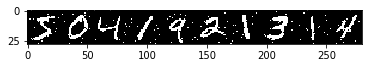

In [20]:
showImage(original10)

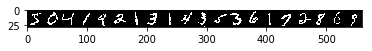

In [21]:
showImage(allBuilt)

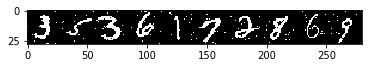

In [22]:
showImage(original20)

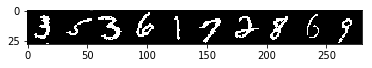

In [23]:
showImage(second10)

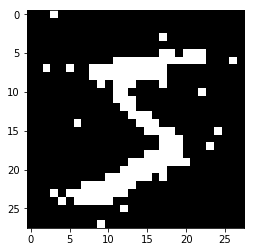

In [24]:
showImage(bin_images[0])

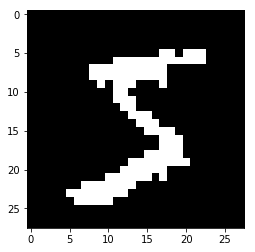

In [25]:
showImage(preprocessing.binarize((newQList[0] * bin_images[0]), threshold=0.5, copy=False))

In [26]:
pd.DataFrame(eValues)

,0,1,2,3,4,5,6,7,8,9,10
0,-425.347929,-3405.666353,-3557.287073,-3560.931573,-3560.987327,-3560.993045,-3560.994302,-3560.994630,-3560.994717,-3560.994741,-3560.994747
1,-431.074730,-3348.878768,-3520.225046,-3524.501031,-3524.826770,-3524.851626,-3524.853342,-3524.853468,-3524.853479,-3524.853480,-3524.853480
2,-443.899917,-3431.427147,-3595.446488,-3595.655566,-3595.662593,-3595.663231,-3595.663302,-3595.663310,-3595.663311,-3595.663311,-3595.663311
3,-434.999207,-3537.052500,-3723.411264,-3723.798649,-3723.798982,-3723.798982,-3723.798982,-3723.798982,-3723.798982,-3723.798982,-3723.798982
4,-433.090420,-3424.198558,-3605.580148,-3606.360341,-3606.356581,-3606.356379,-3606.356365,-3606.356364,-3606.356364,-3606.356364,-3606.356364
5,-405.359546,-3355.733370,-3518.682241,-3525.843527,-3527.026673,-3527.205790,-3527.229001,-3527.231944,-3527.232317,-3527.232364,-3527.232370
6,-402.193095,-3559.741329,-3760.980992,-3761.406247,-3761.398190,-3761.393945,-3761.392719,-3761.392379,-3761.392286,-3761.392260,-3761.392253
7,-438.726128,-3419.931757,-3571.757238,-3573.782350,-3573.885387,-3573.890541,-3573.890814,-3573.890831,-3573.890832,-3573.890833,-3573.890833
8,-448.347160,-3578.368195,-3763.313085,-3766.139670,-3766.199662,-3766.201435,-3766.201491,-3766.201493,-3766.201493,-3766.201493,-3766.201493
9,-416.275133,-3442.487869,-3604.897826,-3606.871376,-3606.970239,-3606.982313,-3606.984870,-3606.985510,-3606.985676,-3606.985720,-3606.985732
